# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023

# Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns


import tools
cm = 1./2.54


# Reload module (for updates)

In [2]:
import importlib
cm = 1./2.54
importlib.reload(tools)
tools.set_theme( white_font=True )
# tools.plot_test_figure()

# Lectures des différentes catégories
<span style="color:red"> **Lire et compter empty cells ?** </span>
<span style="color:red"> **Autre méthode rapide ?** </span>

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    categories_0 = file.readline()[:-1].split('\t')
    # print('n \\t: {:}'.format( len(line.split('\t')) ) )
    # print(line)
    # while True:
    #     line = file.readline()[:-1]
    #     if line is None: break    
    # print(file.readline())
    # print(file.readline())
print('categories:', categories_0 )

categories: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil',

# Définitions keys to keep/drop

In [4]:
# lst of keywords for categories that must be kept
keep_keys = '|'.join( ['nutriscore', 'labels'] )
# lst of keywords for categories that must be dropped
drop_keys = '|'.join( ['image', 'brands', 'url', 'abbreviated_product_name', 'generic_name', 'packaging'] )

categories = pd.Series( categories_0 )[~pd.Series( categories_0 ).str.contains( drop_keys ) ].to_list()
# print( categories_to_load )
del drop_keys

# chargement des données

In [5]:
data = pd.DataFrame()

dtypes = { key:'category' for key in ['nova_group', 'nutriscore_grade'] }

for key in ['code', 'traces', 'traces_en', 'traces_tags',
            'origins_en', 'origins_tags', 'purchase_places',
            'manufacturing_places', 'manufacturing_places_tags',
            'origins', 'food_groups_tags','ingredients_from_palm_oil_tags',
            'ingredients_that_may_be_from_palm_oil_tags',
            'emb_codes_tags', 'food_groups', 'food_groups_en',
            'cities_tags', 'ecoscore_grade_fr', 'emb_codes',
            'allergens', 'additives',
            ]:
    dtypes[key]= 'object'


# data = dd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
# data = data.compute()

if False:
    data = pd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
    data.to_pickle( 'data0.pkl')
else:
    data = pd.read_pickle( 'data0.pkl' )
# data.head()

# dtype = { 'nova_group':'category', 'nutriscore_grade':'category', 'additives': 'object' , 'abbreviated_product_name': 'object', 'allergens': 'object', 'cities_tags': 'object', 'code': 'object', 'ecoscore_grade_fr': 'object', 'emb_codes': 'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo': 'object', 'food_groups': 'object', 'food_groups_en': 'object', 'food_groups_tags': 'object', 'generic_name': 'object', 'ingredients_from_palm_oil_tags': 'object', 'ingredients_that_may_be_from_palm_oil_tags': 'object', 'manufacturing_places': 'object', 'manufacturing_places_tags': 'object', 'origins': 'object', 'origins_en': 'object', 'origins_tags': 'object', 'packaging_text': 'object', 'purchase_places': 'object', 'traces': 'object', 'traces_en': 'object', 'traces_tags': 'object'}



# data = dd.read_csv('openfood_OC.csv', delimiter ='\t', dtype=dtype)
# data = data.compute()

# # data = pd.read_csv('openfood_OC.csv', delimiter='\t', dtype=dtype)
# data.head()

# Détection des doublons
* doublons complets: <span style="color:orange"> $\rightarrow$ pas de doublon complet sur ce jeu de données </span>

1. code: <span style="color:orange">  prendre le plus récent ou le plus complet si même date </span>
2. si même date: <span style="color:orange"> prendre le plus complet </span>

In [6]:
duplicated_codes = data['code'].duplicated(keep=False)

# duplicated_full = data.loc[duplicated_codes,:].duplicated(keep=False)
# display( duplicated_full )

df_tmp = data.loc[duplicated_codes, :].copy()
df_tmp['n filled'] = len(data.keys()) - df_tmp.isnull().sum(1)

df_tmp.sort_values( by=['code', 'last_modified_datetime', 'n filled'] , inplace=True )

print('DataFrame of the duplicated rows (code)')
display( df_tmp[ ['code', 'last_modified_datetime', 'n filled'] ] )

indexes_to_drop = df_tmp.index[::2] 

if len(indexes_to_drop) > 0:
    print('indexes to rows to drop:', indexes_to_drop )
    data.drop( index= df_tmp.index[::2] , inplace=True )
else:
    print('no row to drop')

del df_tmp, indexes_to_drop

DataFrame of the duplicated rows (code)


code last_modified_datetime  n filled
421527  31843340000818   2021-08-17T06:35:03Z        36
349035  31843340000818   2022-02-11T08:47:36Z        38
61995    3560070278831   2021-04-17T07:44:17Z        53
188851   3560070278831   2022-02-10T18:03:06Z        59
270028   3700320230572   2021-08-24T12:58:09Z        22
749882   3700320230572   2021-08-24T12:58:58Z        39
480000   7071688002962   2021-07-13T14:26:35Z        47
477267   7071688002962   2021-07-13T14:26:35Z        52

indexes to rows to drop: Int64Index([421527, 61995, 270028, 480000], dtype='int64')


# Remove empty and some usused/unusable? columns

In [7]:
n = len(data) # number of samples
sum_isnull = data.isnull().sum() # number of null data for each column

In [8]:
n_null_lim_drop = int(0.7*n)

categories_full = sum_isnull[ sum_isnull == 0].index.to_list()
print('\nFull categories:', categories_full)

categories_hollow = sum_isnull[ sum_isnull > n_null_lim_drop].index.to_list()
print('\nHollow categories:', categories_hollow)

# drop caterories to keep (with keep_keys)
removed_cat = pd.Series( categories_hollow )
removed_cat = removed_cat[ ~removed_cat.str.contains(keep_keys) ].to_list()

# check is completely empty categories remains
removed_cat += [ key for key in sum_isnull[ sum_isnull == n].index if not key in removed_cat ]

# check for dupplicated entry and if key are still in DataFrame
removed_cat = [ key for i, key in enumerate( removed_cat ) if (not key in removed_cat[:i]) and (key in data.keys()) ]

print('\nRemoved categories:' )
if False: # vertical display
    display( pd.DataFrame( {'categorie': [key for key in removed_cat] ,
                            'n null': [sum_isnull[key] for key in removed_cat] } ) )
else: # horizontal display
    display( pd.DataFrame( { key:[np.round( sum_isnull[key]/n*100, 2)] for key in removed_cat } , index=['% isnull'] ) )

# print('')
# data.memory_usage()

if True: data.drop( columns=removed_cat, inplace=True )
# if True: data = data.drop( columns=removed_cat )

# print('')
# data.memory_usage()

# msno.bar( data )


Full categories: ['code', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'states', 'states_tags', 'states_en']

Hollow categories: ['quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-ac

quantity  origins  origins_tags  origins_en  manufacturing_places  \
% isnull     74.45    95.73         95.74       95.74                 93.86   

          manufacturing_places_tags  emb_codes  emb_codes_tags  cities  \
% isnull                      93.86      94.12           94.12   100.0   

          cities_tags  purchase_places  stores  allergens  allergens_en  \
% isnull        96.26            92.42   86.73      90.91         100.0   

          traces  traces_tags  traces_en  serving_size  serving_quantity  \
% isnull    95.0        93.83      93.83         76.08             76.26   

          no_nutriments  additives  additives_tags  additives_en  \
% isnull          100.0      100.0           80.27         80.27   

          ingredients_from_palm_oil  ingredients_from_palm_oil_tags  \
% isnull                      100.0                           99.33   

          ingredients_that_may_be_from_palm_oil  \
% isnull                                  100.0   

          ingredients_that_may_be_from_palm_oil_tags  brand_owner  \
% isnull                                       97.98        86.72   

          ecoscore_score_fr  ecoscore_grade_fr  energy-kj_100g  \
% isnull              76.71              76.71           92.74   

          energy-from-fat_100g  -butyric-acid_100g  -caproic-acid_100g  \
% isnull                 99.95               100.0               100.0   

          -caprylic-acid_100g  -capric-acid_100g  -lauric-acid_100g  \
% isnull                100.0              100.0              100.0   

          -myristic-acid_100g  -palmitic-acid_100g  -stearic-acid_100g  \
% isnull                100.0                100.0               100.0   

          -arachidic-acid_100g  -behenic-acid_100g  -lignoceric-acid_100g  \
% isnull                 100.0               100.0                  100.0   

          -cerotic-acid_100g  -montanic-acid_100g  -melissic-acid_100g  \
% isnull               100.0                100.0                100.0   

          monounsaturated-fat_100g  polyunsaturated-fat_100g  \
% isnull                     97.78                     97.78   

          omega-3-fat_100g  -alpha-linolenic-acid_100g  \
% isnull              99.9                       100.0   

          -eicosapentaenoic-acid_100g  -docosahexaenoic-acid_100g  \
% isnull                        100.0                       100.0   

          omega-6-fat_100g  -linoleic-acid_100g  -arachidonic-acid_100g  \
% isnull             99.97                100.0                   100.0   

          -gamma-linolenic-acid_100g  -dihomo-gamma-linolenic-acid_100g  \
% isnull                       100.0                              100.0   

          omega-9-fat_100g  -oleic-acid_100g  -elaidic-acid_100g  \
% isnull             99.99             100.0               100.0   

          -gondoic-acid_100g  -mead-acid_100g  -erucic-acid_100g  \
% isnull               100.0            100.0              100.0   

          -nervonic-acid_100g  trans-fat_100g  cholesterol_100g  \
% isnull                100.0           87.88             87.69   

          -sucrose_100g  -glucose_100g  -fructose_100g  -lactose_100g  \
% isnull          100.0          100.0           100.0          100.0   

          -maltose_100g  -maltodextrins_100g  starch_100g  polyols_100g  \
% isnull          100.0                100.0        99.97         99.83   

          fiber_100g  soluble-fiber_100g  insoluble-fiber_100g  casein_100g  \
% isnull       72.56               99.84                 99.85        100.0   

          serum-proteins_100g  nucleotides_100g  alcohol_100g  vitamin-a_100g  \
% isnull                99.99             100.0         98.88           90.26   

          beta-carotene_100g  vitamin-d_100g  vitamin-e_100g  vitamin-k_100g  \
% isnull               100.0           99.53           99.83           99.94   

          vitamin-c_100g  vitamin-b1_100g  vitamin-b2_100g  vitamin-pp_100g  \
% isnull           89.91             98.9 

# Visualisation of NaN for new DataFrame

In [9]:
print(sum_isnull.size, len(categories), len(data.keys()))
with pd.option_context('display.max_rows', None):
    print( sum_isnull[data.keys()].sort_values() )

175 175 44
code                                                          0
created_t                                                     0
created_datetime                                              0
last_modified_t                                               0
last_modified_datetime                                        0
states_tags                                                   0
states                                                        0
states_en                                                     0
creator                                                       1
pnns_groups_2                                               108
pnns_groups_1                                               108
countries                                                  2300
countries_tags                                             2301
countries_en                                               2301
product_name                                              31080
energy_100g                  

<AxesSubplot: >

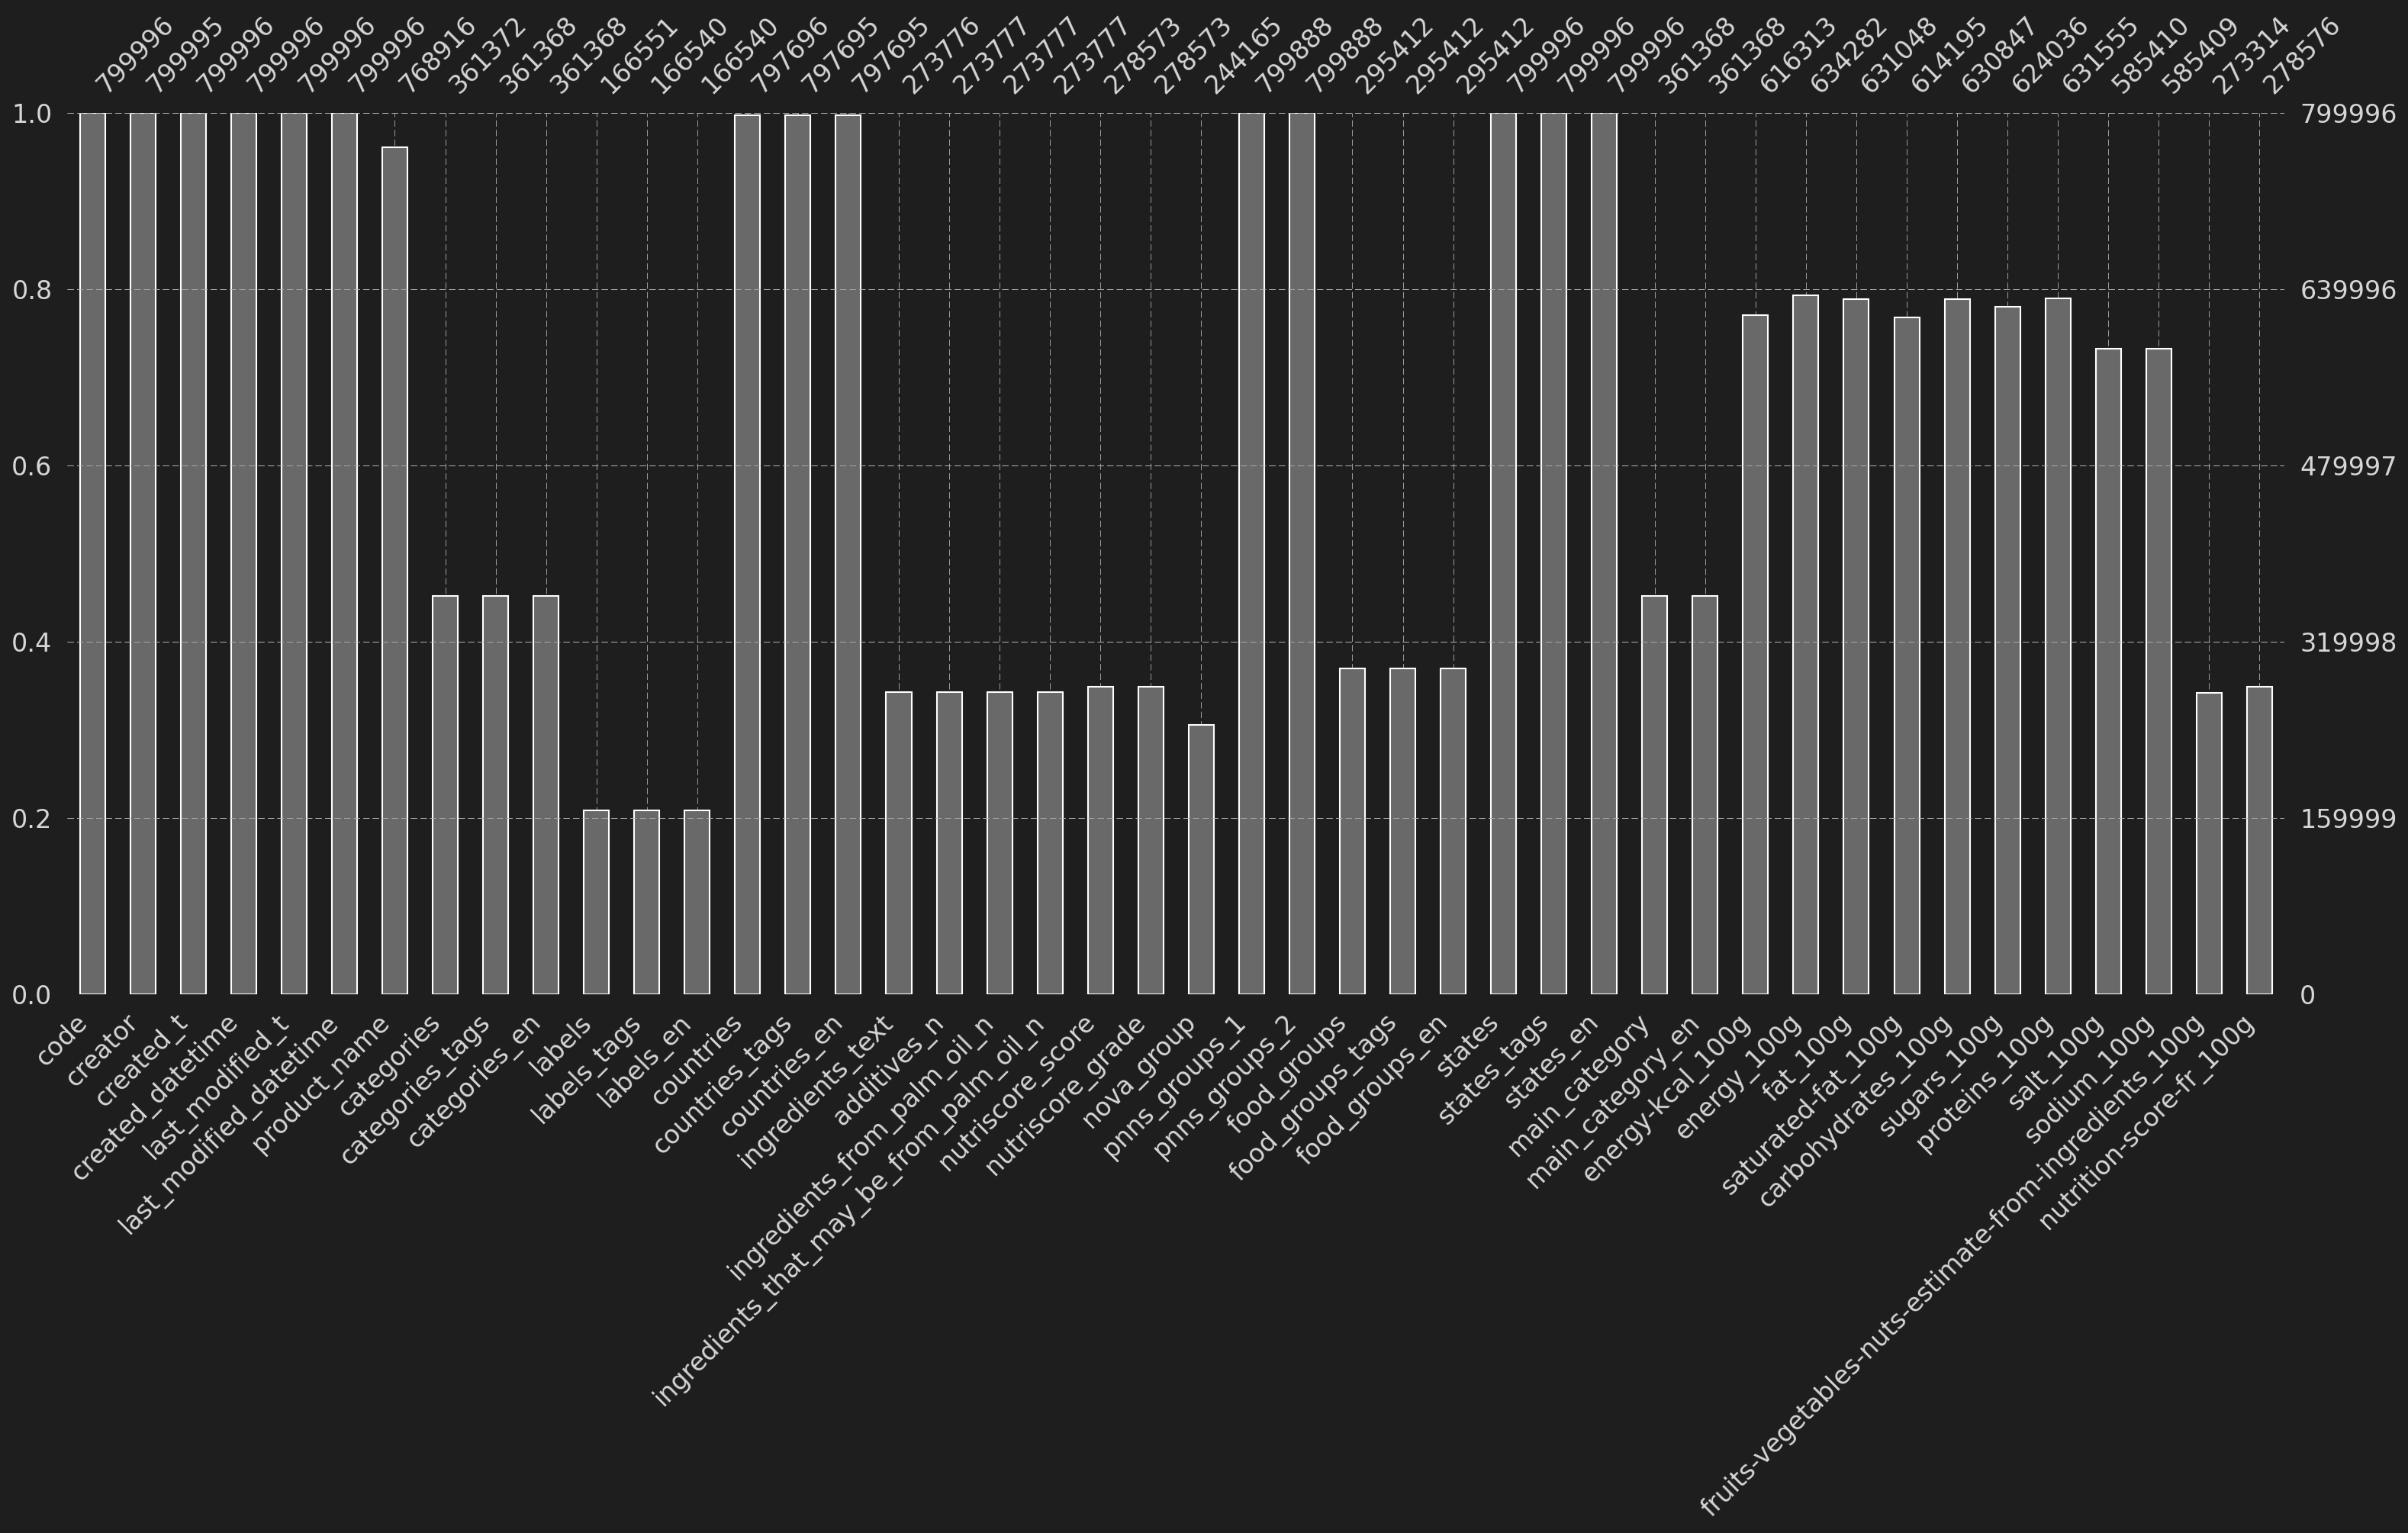

In [10]:
msno.bar( data )

# DTYPES

In [11]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                       object
creator                                                    object
created_t                                                   int64
created_datetime                                           object
last_modified_t                                             int64
last_modified_datetime                                     object
product_name                                               object
categories                                                 object
categories_tags                                            object
categories_en                                              object
labels                                                     object
labels_tags                                                object
labels_en                                                  object
countries                                                  object
countries_tags                                             object
countries_

# Listes des catégories: string / float64 / others

In [12]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )
# ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )
categories_string = []
# print('\nstrings to lowercase')
for key in categories_others: 
    # print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    # data[key].str.lower()

categories_others = [key for key in categories_others if not key in categories_string]
print("float categories:", categories_float )
print("\nstring categories:", categories_string )
print("\nothers categories:", categories_others )


float categories: ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

string categories: ['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

others categories: ['created_t', 'last_modified_t', 'nutriscore_grade', 'nova_group']


# Analyse variables category
1. rename_categories 
    - nitriscore_grade $\rightarrow$ upper
    - nova_group $\rightarrow$ int
1. str.lower
1. replace <span style="color:orange"> unknown </span> $\rightarrow$ <span style="color:orange"> NaN </span> in 'pnn_groups'
1. food_groups: <span style="color:orange"> 'en:' </span> $\rightarrow$ <span style="color:orange"> '' </span>, <span style="color:orange"> '-' </span> $\rightarrow$ <span style="color:orange"> ' ' </span> (for readability)
1. print first values for each category

In [13]:
string_catergories_to_value_count = ['nova_group', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups']

# Modification of categories (nitriscore_grade -> upper, nova_group -> int)
data['nutriscore_grade'] = data['nutriscore_grade'].cat.rename_categories( {cat:cat.upper() for cat in data['nutriscore_grade'].cat.categories} )
data['nova_group'] = data['nova_group'].cat.rename_categories( {cat:int(float(cat)) for cat in data['nova_group'].cat.categories} )


# lower all string
for key in string_catergories_to_value_count:
    print('\n', key, data[key].dtype.kind)
    # if data[key].dtype.kind != 'O': continue # Check if dtyp is object
    # if not pd.api.types.is_string_dtype( data[key].dtype ): continue
    if data[key].dtype != 'object': continue
    data[key] = data[key].str.lower()


# replace "en:" and "-" in food_groups to improve readability
data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )


# replace 'unknown' to NaN
data.replace( {'pnns_groups_1':'unknown',
                'pnns_groups_2':'unknown',
                'food_groups':'unknown'}, np.nan, inplace=True )
# data.replace( { 'pnns_groups_1':{'unknown':np.nan},
#                 'pnns_groups_2':{'unknown':np.nan} }, inplace=True )



# astype category
# data[string_catergories_to_value_count] = data[string_catergories_to_value_count].astype('category')

for key in string_catergories_to_value_count:
    print('\n', key, data.dtypes[key])
    i = 0
    for value in data[key] :
        if pd.isnull( value ) : continue
        print(value )
        i += 1
        if i == 10: break

dico_value_counts = { key: data[key].value_counts().sort_values() for key in string_catergories_to_value_count }


 nova_group O

 nutriscore_grade O

 pnns_groups_1 O

 pnns_groups_2 O

 food_groups O

 nova_group category
3
4
3
3
3
4
4
1
1
4

 nutriscore_grade category
D
E
D
A
D
B
B
B
A
D

 pnns_groups_1 object
beverages
milk and dairy products
beverages
fish meat eggs
fish meat eggs
milk and dairy products
fat and sauces
beverages
fish meat eggs
fish meat eggs

 pnns_groups_2 object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
meat
cheese
dressings and sauces
fruit juices
meat
meat

 food_groups object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
poultry
cheese
dressings and sauces
unsweetened beverages
poultry
poultry


nova_group  nutriscore_grade  pnns_groups_1  pnns_groups_2  food_groups
0           4                 5             10             40           45

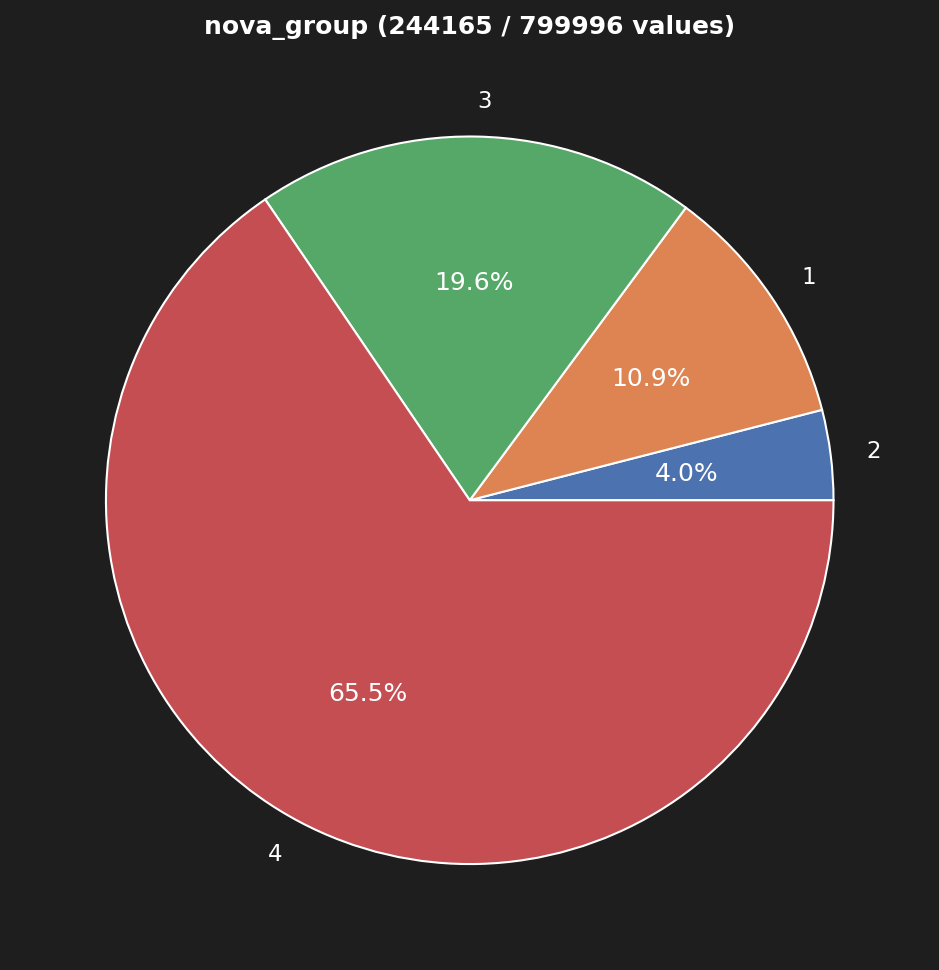

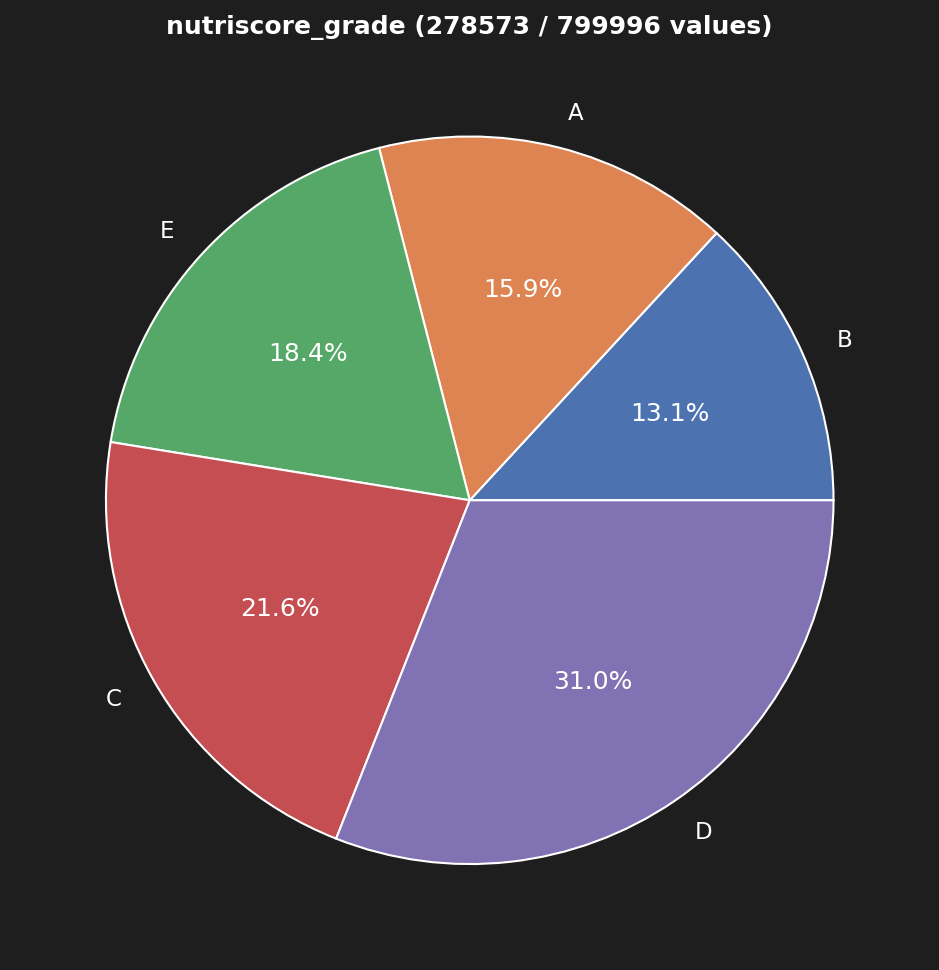

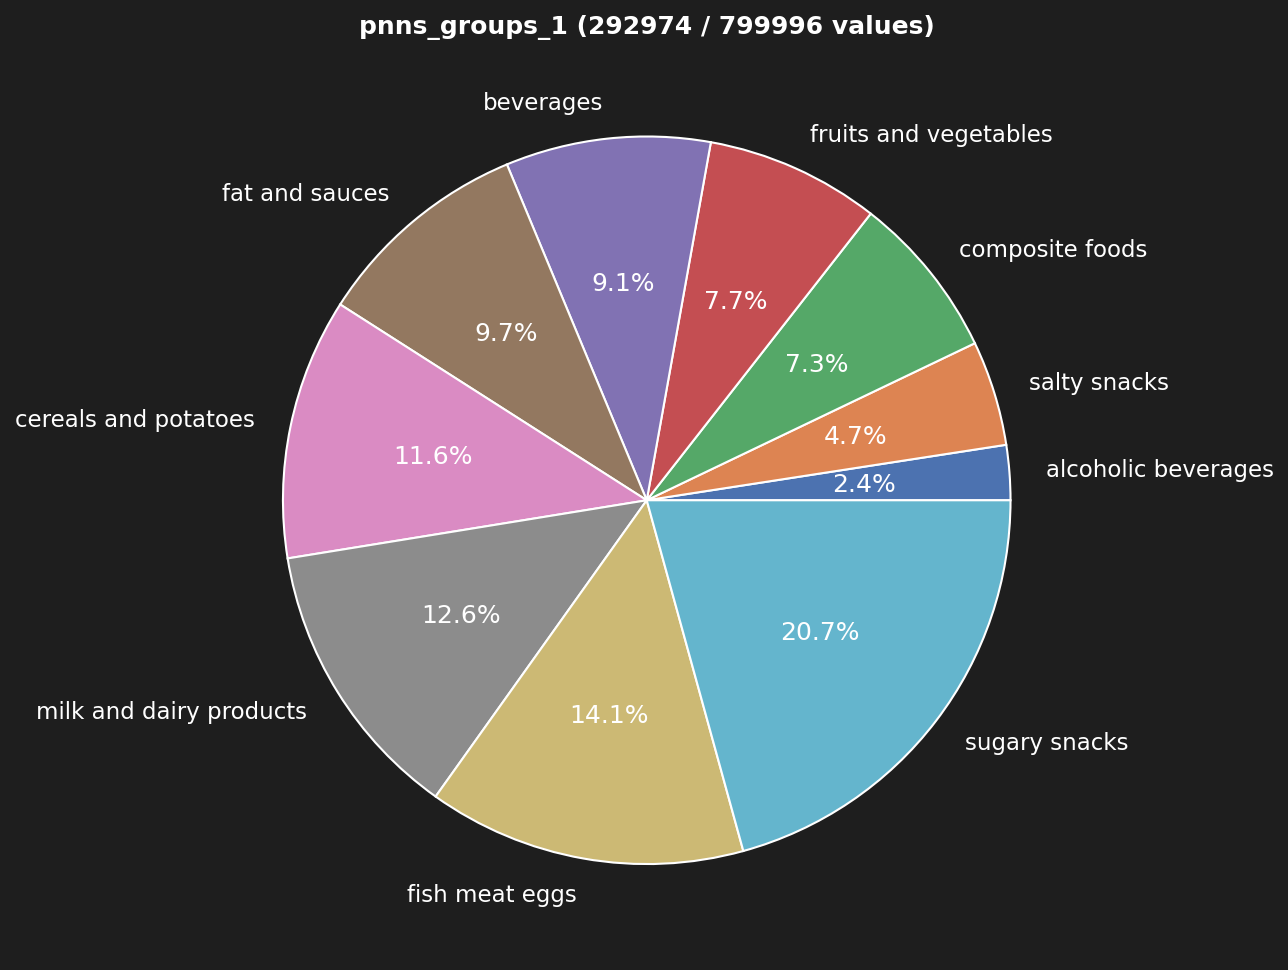

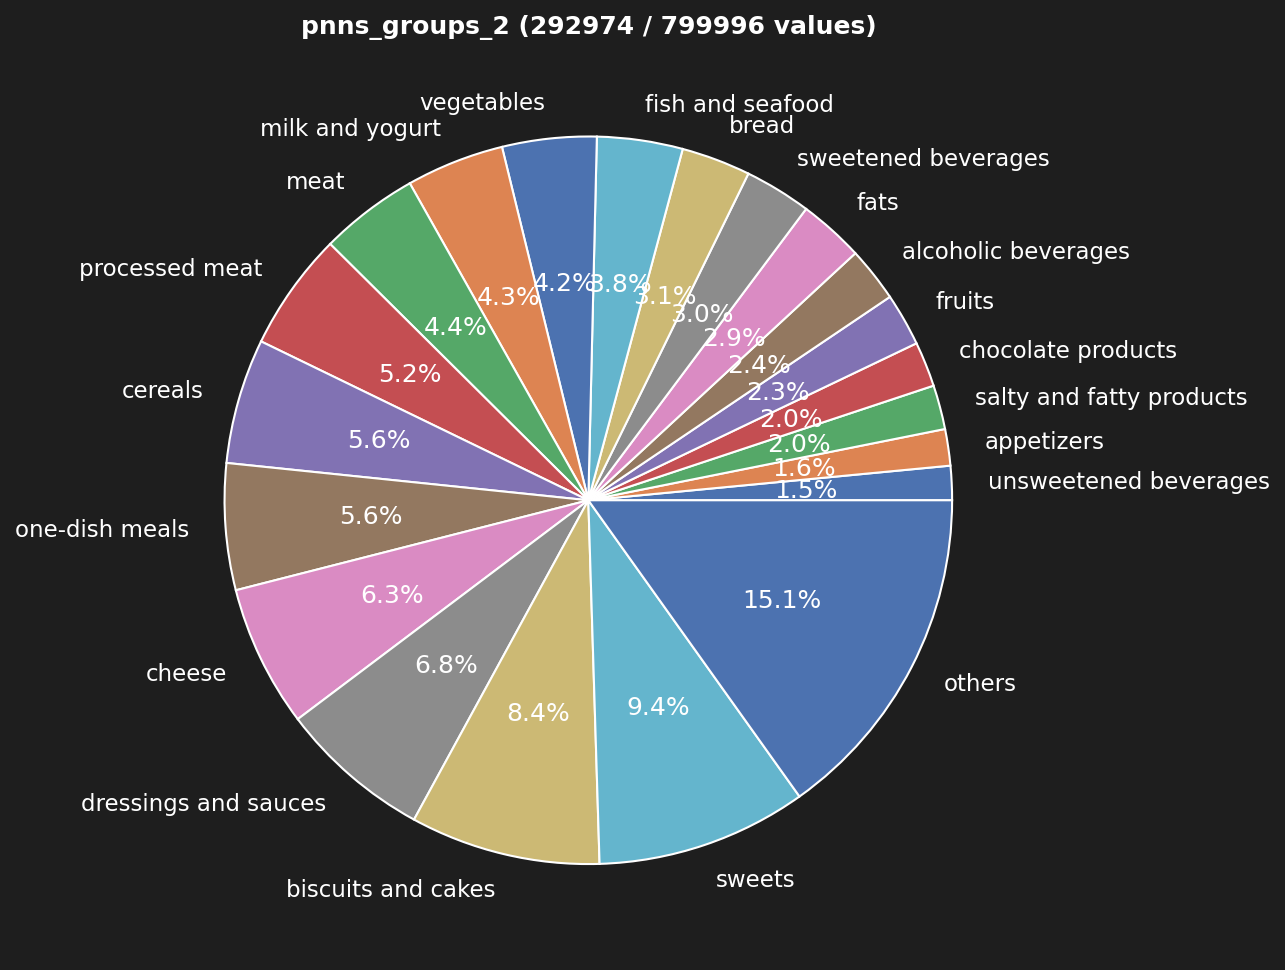

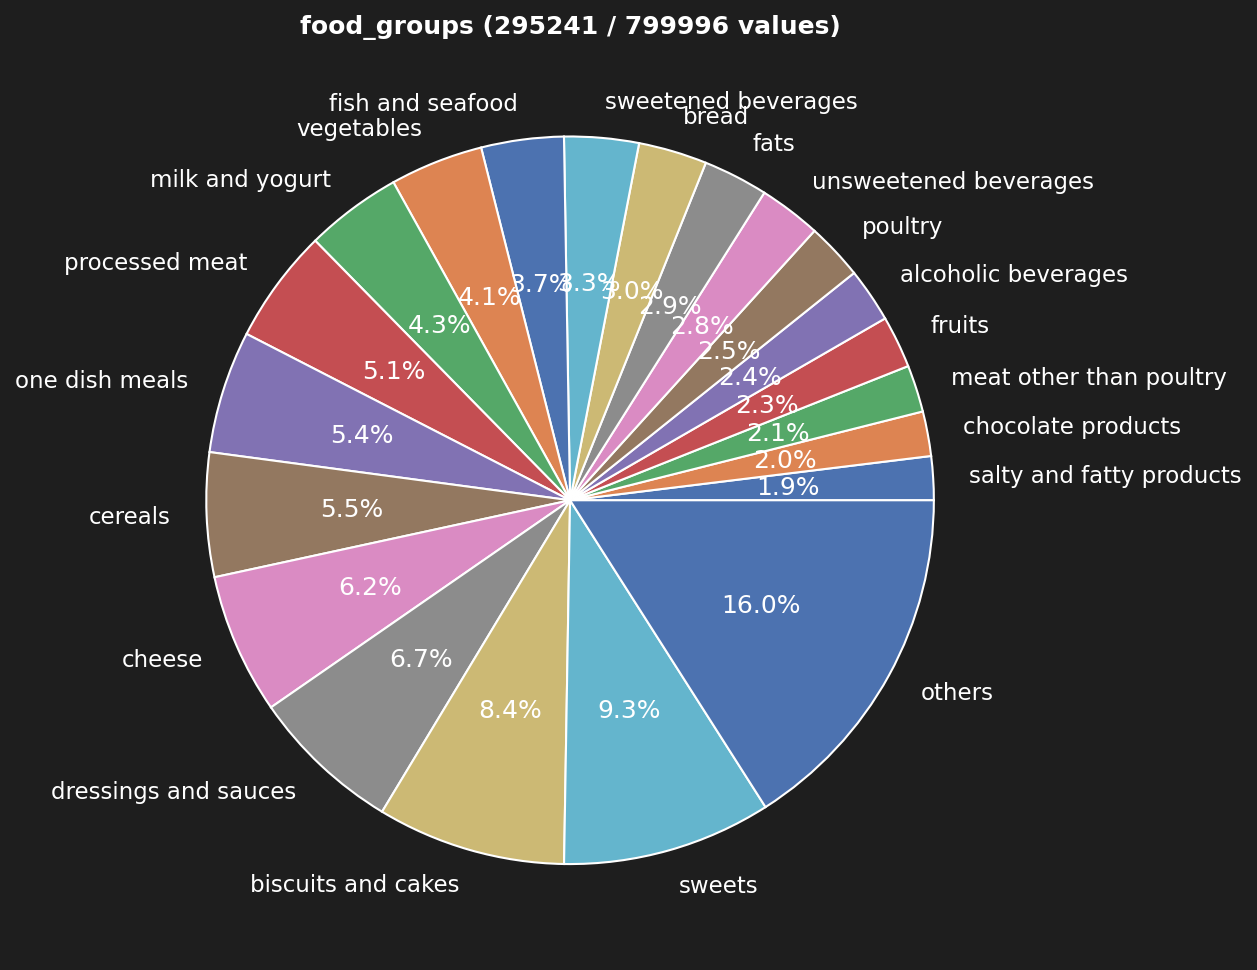

In [14]:
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in string_catergories_to_value_count} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

# print('min counts', data_value_counts.iloc[0,:].min() )

n_lim_categories = 20
for key in string_catergories_to_value_count:
    sr_plot = dico_value_counts[key]
    n_sum = sr_plot.sum()

    if dico_value_counts[key].size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, n), weight='bold')
    ax.set_ylabel('')

    # fig, ax = plt.subplots( figsize=(20*cm, 10*cm*(data_value_counts[key][0]/10)) )
    # pd.Series( dico_value_counts[key] ).plot( kind='barh' , ax=ax )
    # ax.set_title(key)

if False: # barplot
    cat_pos = np.arange( len(string_catergories_to_value_count) )
    print(cat_pos)
    fig, ax = plt.subplots( figsize=(20*cm,10*cm))
    if True: # horizontal
        ax.bar( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_xticks(cat_pos, labels=string_catergories_to_value_count)
    else:
        ax.barh( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_yticks(cat_pos, labels=string_catergories_to_value_count)
        ax.invert_yaxis()  # labels read top-to-bottom

    fig.tight_layout()
    del cat_pos


# Comparaison pnns_groups_1/_2 et food_groups: tableaux de contingences
<span style="color:red"> (+ seuil ? $\rightarrow$ $\chi^2$) </span>

nan in data_chi:
pnns_groups_1    507022
pnns_groups_2    507022
food_groups      504755
dtype: int64

nan in data_chi:
pnns_groups_1    0
pnns_groups_2    0
food_groups      0
dtype: int64


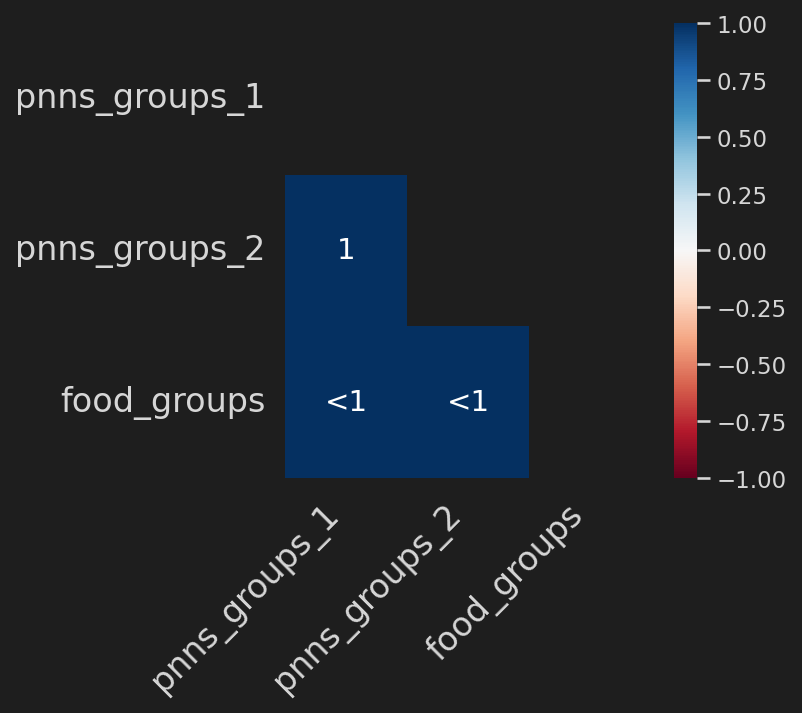

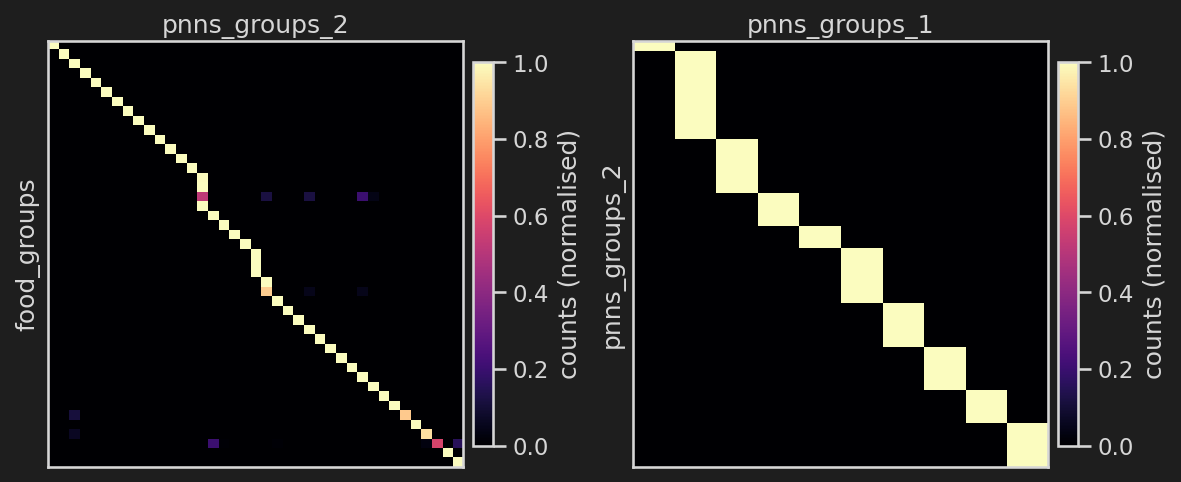

In [15]:
data_chi = data[['pnns_groups_1', 'pnns_groups_2', 'food_groups']].copy()

print('nan in data_chi:')
print( data_chi.isnull().sum() )


fig, ax = plt.subplots( figsize=(10*cm,10*cm))
msno.heatmap( data_chi , ax=ax )

data_chi_isnull = data_chi.isnull()

# drop all rows with at least one NaN
data_chi.drop( data_chi.index[ data_chi_isnull.sum(1) > 0 ] , inplace=True )

# check drop
print('\nnan in data_chi:')
print( data_chi.isnull().sum() )

type_plot = ['xi', 'count'][1]

X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X1, Y1 = 'food_groups', 'pnns_groups_2'

maps = [ None, None ]
fig, axs = plt.subplots( 1,2, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) ] ):
    xi_ij, contingences = tools.chi2( data_chi, X, Y )

    image = contingences.values
    image = image[:-1,:-1] / image[:-1,-1:]
    argmax_col = image.argmax(1)
    maps[i] = pd.Series( { key_in:contingences.keys()[imax_col] for key_in, imax_col in zip(contingences[:-1].index, argmax_col)} )
    argsort_rows = argmax_col.argsort()
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    # figsize = tools.image_size_from_height_and_shape( 12*cm, image.shape, xmargin=1*cm)
    # print( 'figsize', figsize)
    # fig, ax = plt.subplots( figsize=figsize )
    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    # axs[i].axis('off')
    # cb = plt.colorbar( im, ax=ax, orientation='horizontal', pad=0.01, label=r'$\xi_{ij} \, / \, \xi_{n}$')
    cb = plt.colorbar( im, ax=axs[i], pad=0.02, shrink=[0.9, 0.9][i], label=label)

axs[0].set_xlabel(Y1)
axs[0].set_ylabel(X1)

axs[1].set_xlabel(Y2)
axs[1].set_ylabel(X2)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 


# display( contingences )
# display( maps[0] )
# display( maps[1] )

# map food_group -> pnns_groups_1
# there are some 'pnns_groups_1' values in the 'food_groups' for which 'pnns_groups_1' is NaN
food_to_pnns_groups = pd.concat( (maps[1][maps[0]], 
                pd.Series( {key:key for key in dico_value_counts['pnns_groups_1'].keys()} ) ) )


fig.tight_layout( pad=0.4 )
plt.show()
del image, cb, im, axs, fig
del X1,Y1, X2,Y2, maps

# Gestion des NaN dans "pnns_groups_1"
1. détection des NaN
1. chercher NaN "pnns_groups_1" et non NaN "food_groups"
1. remplacer selon "food_groups" et "food_to_pnns_groups"

In [16]:
print( "sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: {:}".format( 
    ( data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['pnns_groups_2'] ).sum() ) )

sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: 0


In [17]:
b_map = data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['food_groups']
# display( food_to_pnns_groups)
data.loc[b_map, 'pnns_groups_1'] = food_to_pnns_groups[ data.loc[b_map,'food_groups'] ].values

# Analyse variables float
Mis à NaN:
- (nitruscore < -15) & (nutriscore > 40)
- values < 0 (sauf nutriscore)
- values > 100 (sauf energy)
- energy > 900 (kcal) <span style="color:orange"> compétence métier </span>
- sodium > salt
- saturated-fat > fat
- sugars > carbohydrates

Check $\sum$("proteins", "carbohydrates", "fat" ) > 100

<span style="color:red"> Quid de la somme > 100 ? quelle limite ? </span>

In [18]:
# A VOIR POUR SPEED UP ?
if False:
    _, bp = pd.DataFrame.boxplot(df, return_type='both')

    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    boxes = [box.get_ydata() for box in bp["boxes"]]
    medians = [median.get_ydata() for median in bp["medians"]]
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

product_name  proteins_100g  carbohydrates_100g  \
369                            Sucre roux           0.00          100.000000   
1072                      sweet soy sauce           2.60           99.800000   
1103          Gaufres sucrées au chocolat          23.00           53.299999   
1362            Pisto con salmon y quinoa          30.10           45.480000   
1366    Fisherman's Friend pomme cannelle           0.00           98.800000   
...                                   ...            ...                 ...   
797669            Lindt HELLO XMAS Cherry          46.70           54.000000   
797687    Zucchero Int. bio Cocco GR230 E           1.80           97.000000   
797873         Les croquants chocolat bio           7.30           67.000000   
798816                    Lenguas Ketydul           5.70           67.100000   
799834                         Mixed nuts          21.43           17.860000   

         fat_100g  sum_100g  
369      0.100000     100.1  
1072     0.000000     102.4  
1103    25.700001     102.0  
1362    29.100000     104.7  
1366     1.300000     100.1  
...           ...       ...  
797669  35.000000     135.7  
797687   1.500000     100.3  
797873  27.000000     101.3  
798816  27.500000     100.3  
799834  64.290000     103.6  

[2239 rows x 5 columns]

nutriscore_score  nutrition-score-fr_100g
count     277591.000000            277594.000000
mean           9.110976                 9.111072
std            8.840131                 8.840151
min          -15.000000               -15.000000
25%            1.000000                 1.000000
50%           10.000000                10.000000
75%           16.000000                16.000000
max           40.000000                40.000000
IQ            15.000000                15.000000

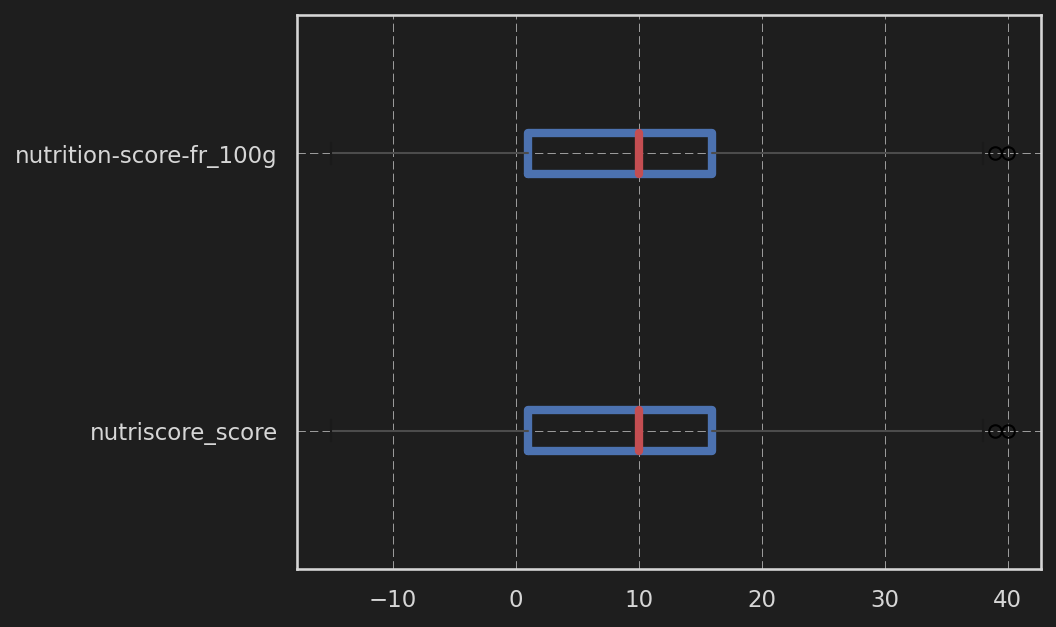

energy-kcal_100g
count     613009.000000
mean         270.542555
std          191.147619
min            0.000000
25%          100.000000
50%          259.000000
75%          400.000000
max          900.000000
IQ           300.000000

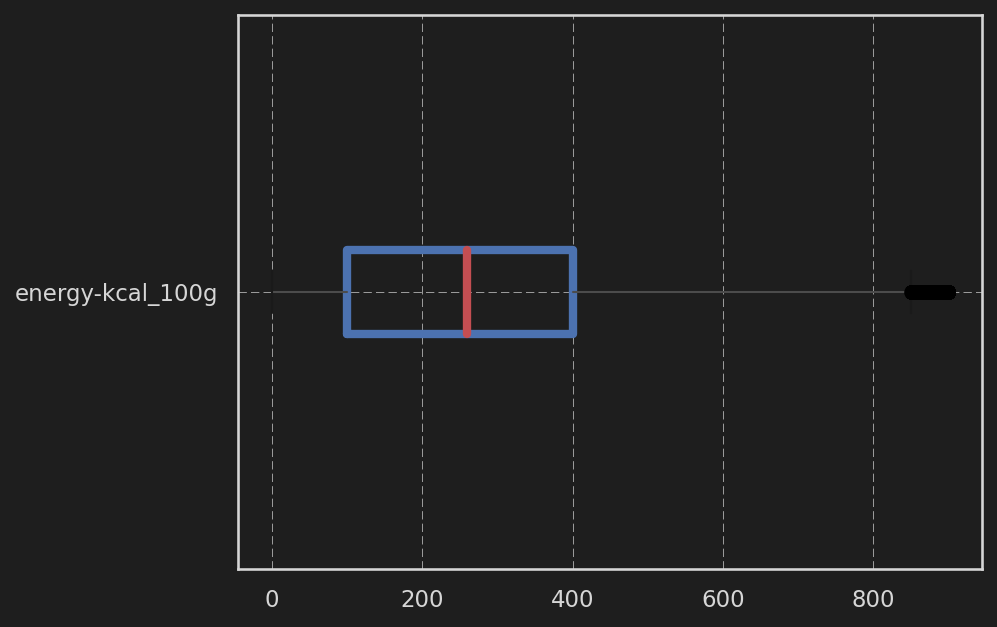

fat_100g  saturated-fat_100g  carbohydrates_100g    sugars_100g  \
count  627690.000000       610569.000000       627529.000000  620299.000000   
mean       13.669906            5.056372           28.078364      13.005056   
std        17.592071            7.756347           27.914560      19.350697   
min         0.000000            0.000000            0.000000       0.000000   
25%         0.800000            0.100000            3.530000       0.600000   
50%         7.000000            1.800000           15.384615       3.570000   
75%        21.210000            7.058824           53.000000      17.400000   
max       100.000000          100.000000          100.000000     100.000000   
IQ         20.410000            6.958824           49.470000      16.800000   

       proteins_100g      salt_100g    sodium_100g  \
count  628226.000000  582539.000000  582533.000000   
mean        8.710977       1.359247       0.543701   
std        10.013554       4.652734       1.861109   
min         0.000000       0.000000       0.000000   
25%         1.330000       0.082500       0.033000   
50%         6.000000       0.582500       0.233000   
75%        12.500000       1.400000       0.560000   
max       100.000000     100.000000      40.000000   
IQ         11.170000       1.317500       0.527000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g  
count                                      272274.000000      
mean                                            8.237656      
std                                            21.662131      
min                                             0.000000      
25%                                             0.000000      
50%                                             0.000000      
75%                                             0.400000      
max                                           100.000000      
IQ                                              0.400000

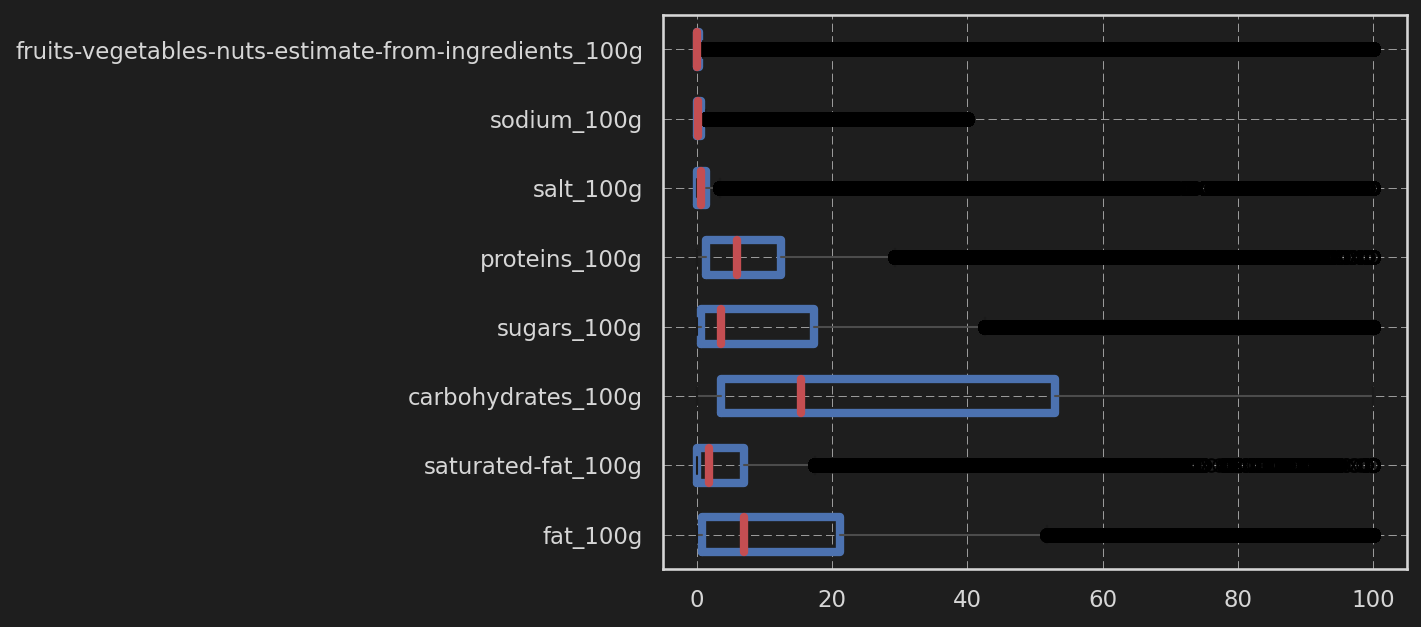

In [19]:
keys = pd.Series( categories_float )
# keys = keys.loc[ keys!='energy_100g' ]
# keys = keys.loc[ keys.str.contains('_100g|score') ]

keys = keys.loc[ keys.str.contains('100g|score') & (keys!='energy_100g') ]
keys_float = keys.copy()
# print(categories_float)
# print('\n', keys.values)


# NUTRI SCORE
key = 'nutriscore_score'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan
key = 'nutrition-score-fr_100g'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan


# ENERGY
key = 'energy-kcal_100g'
data.loc[ (data[key] < 0.) | (data[key] > 900.) ] = np.nan

# (Values < 0.) | (Values > 100.)
for key in keys[ ~keys.str.contains('score|energy') ]:
    data.loc[ (data[key] < 0.) | (data[key] > 100.) ] = np.nan
    
# SODIUM
key = 'sodium_100g'
data.loc[ data[key] > data['salt_100g'], key ] = np.nan

# SUGARS
key = 'sugars_100g'
data.loc[ data[key] > data['carbohydrates_100g'], key ] = np.nan

# SATURATED_FAT
key = 'saturated-fat_100g'
data.loc[ data[key] > data['fat_100g'], key ] = np.nan

# TOTALtext
key = 'sum_100g'
data[key] = data[ ['proteins_100g', 'carbohydrates_100g', 'fat_100g'] ].fillna(0.).sum(axis=1).round(1)


display( data.loc[ np.round( data['sum_100g'], 1)>100. , ['product_name','proteins_100g', 'carbohydrates_100g', 'fat_100g', 'sum_100g']] )

del key


df_describe = data[ keys ].describe()



IQs = df_describe.loc['75%', :] - df_describe.loc['25%', :]
# IQs.rename( index={0:'IQ'}, inplace=True )

# # display(IQs)
df_describe = pd.concat( (df_describe, IQs.to_frame().T) , ignore_index=False )
df_describe.rename( index={0:'IQ'}, inplace=True )

boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')


for keys_tmp in [ keys.astype(str).values[keys.str.contains('score')] , ['energy-kcal_100g'], keys[~keys.str.contains('score|energy')].values ]:
    display( df_describe[keys_tmp] )
    data[keys_tmp].boxplot( showfliers=True, vert=False, boxprops=boxprops, medianprops=medianprops )
    # ax.bxp( df_describe[keys_tmp], boxprops=boxprops, medianprops=medianprops )
    plt.show()
del keys_tmp


# key = 'energy_100g'
# data.loc[ data[key] > df_describe[key]['75%'] + 1.5*df_describe[key]['IQ'] , key ] = np.nan

# df_describe = data[categories_float].describe()
# df_describe.boxplot( showfliers=False, vert=False )
# display( df_describe )


# Nouveau DataFrame et count NaN

In [132]:
keys_categ = ['pnns_groups_1', 'nutriscore_grade', 'nova_group']
key_categ = keys_categ[0]
key_classification = [ 'pnns_groups_1',
                        'nutriscore_score', 
                        'nutriscore_grade',
                        'nova_group',
                     ][3]

# copie des données catégorie, classification et float
data_base = data[keys_categ].copy()
if not key_classification in key_categ:
    data_base[key_classification] = data[key_classification].copy()
data_base[keys_float] = data[keys_float].copy()
isna_base = data_base.isna()
sum_isna_base = isna_base.sum() # sum sur les colonnes
display( sum_isna_base )

key_output = 'energy-kcal_100g'
keys_stats = keys_float[ ~keys_float.str.contains( 'score|fruits') ]
keys_input = keys_stats[ keys_stats != key_output ]

b_inputs = ~isna_base[key_categ] & (~isna_base[keys_input]).all( 1 ) # logical and over all columns
b_outputs = (~isna_base[[key_output, key_classification]]).all( 1 )

data_stats = data_base.loc[ b_inputs & b_outputs , :]

print('Number of available data:')
print('inputs          : {:}'.format( b_inputs.sum() ) )
print('inputs & outputs: {:}'.format( ( b_inputs & b_outputs ).sum() ))


pnns_groups_1                                            505679
nutriscore_grade                                         522405
nova_group                                               556660
nutriscore_score                                         522405
energy-kcal_100g                                         186987
fat_100g                                                 172306
saturated-fat_100g                                       189427
carbohydrates_100g                                       172467
sugars_100g                                              179697
proteins_100g                                            171770
salt_100g                                                217457
sodium_100g                                              217463
fruits-vegetables-nuts-estimate-from-ingredients_100g    527722
nutrition-score-fr_100g                                  522402
dtype: int64

Number of available data:
inputs          : 237430
inputs & outputs: 139760


# Histogrammes

In [ ]:
for key in keys_input:
    fig, ax = plt.subplots()
    data_base[ key ].hist( ax=ax )
    ax.set_title(key)

# Analyse bivariée

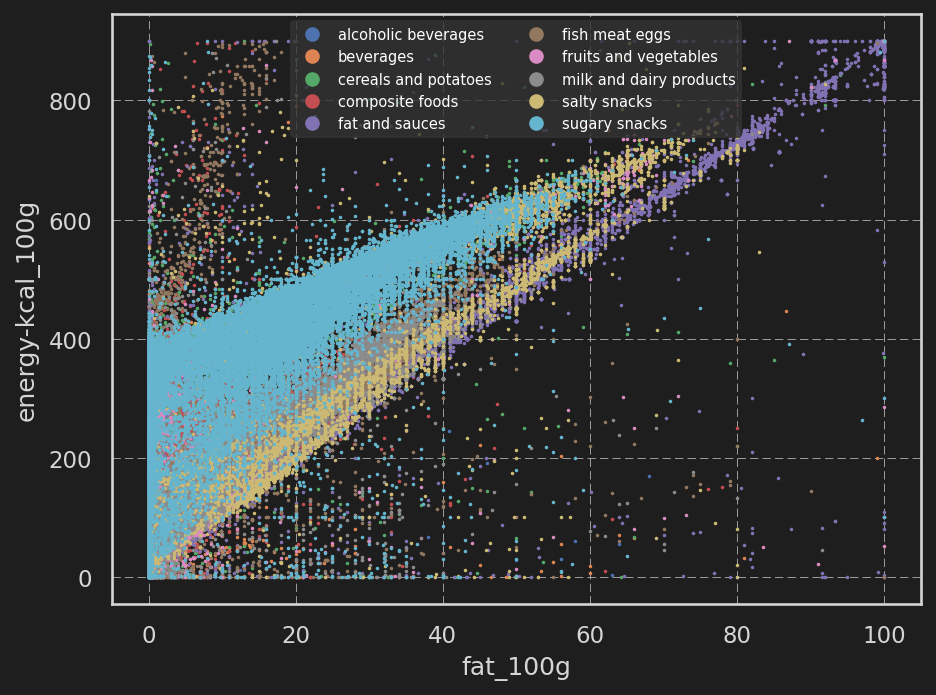

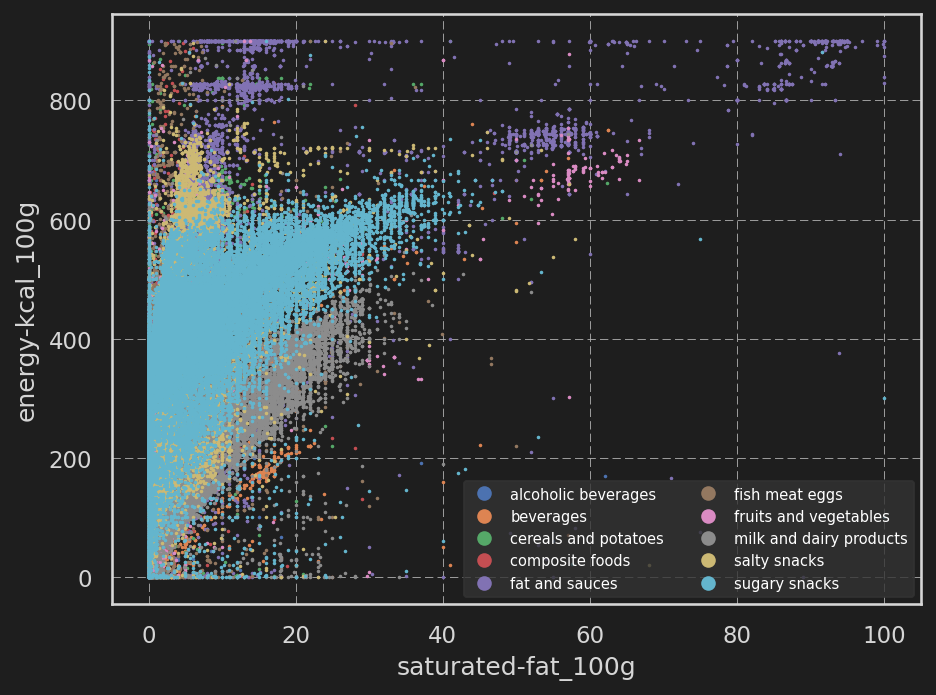

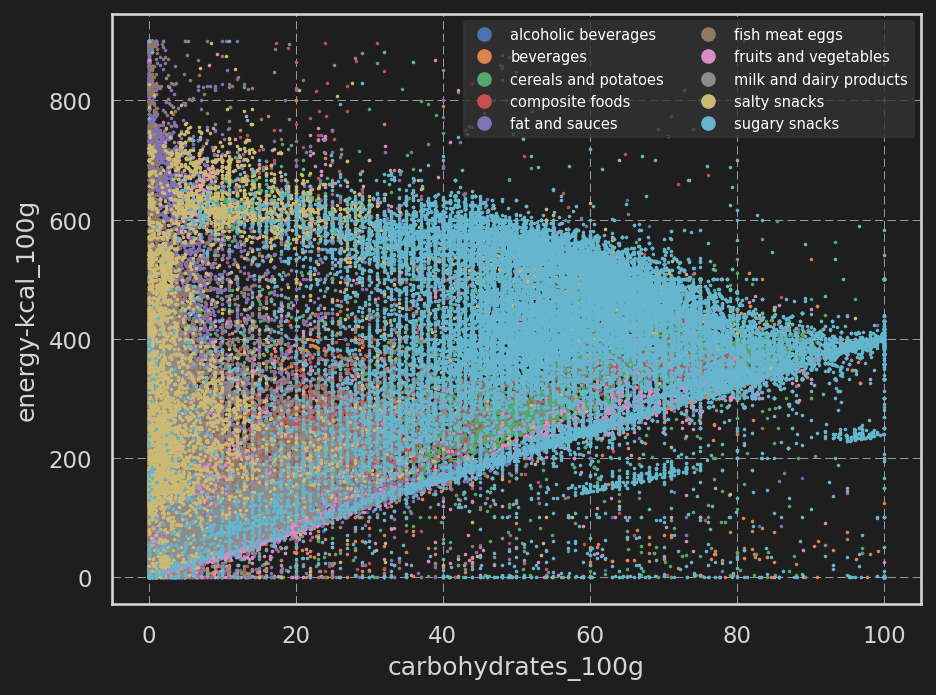

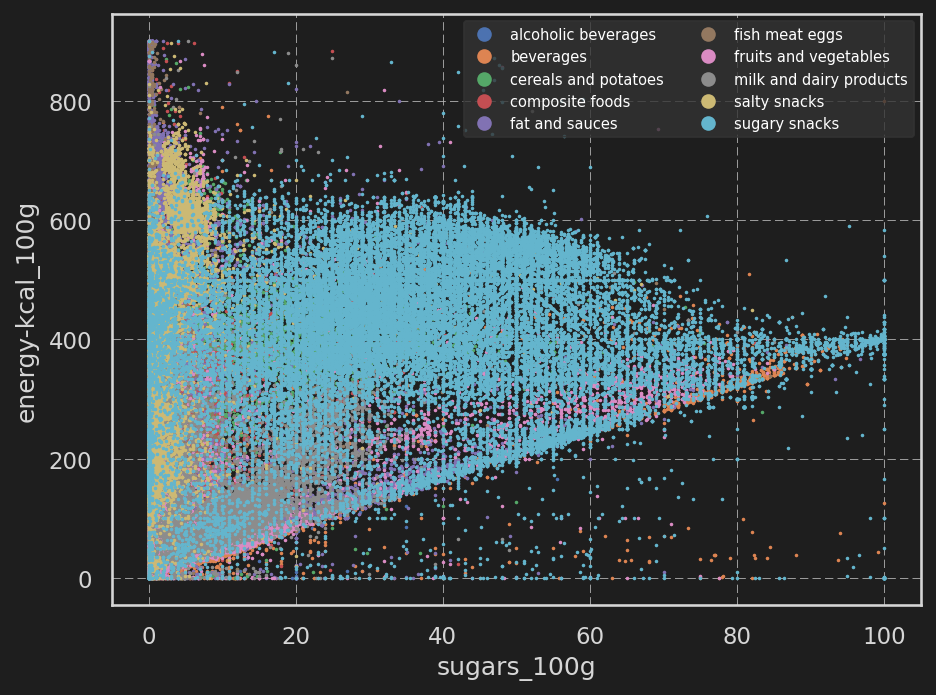

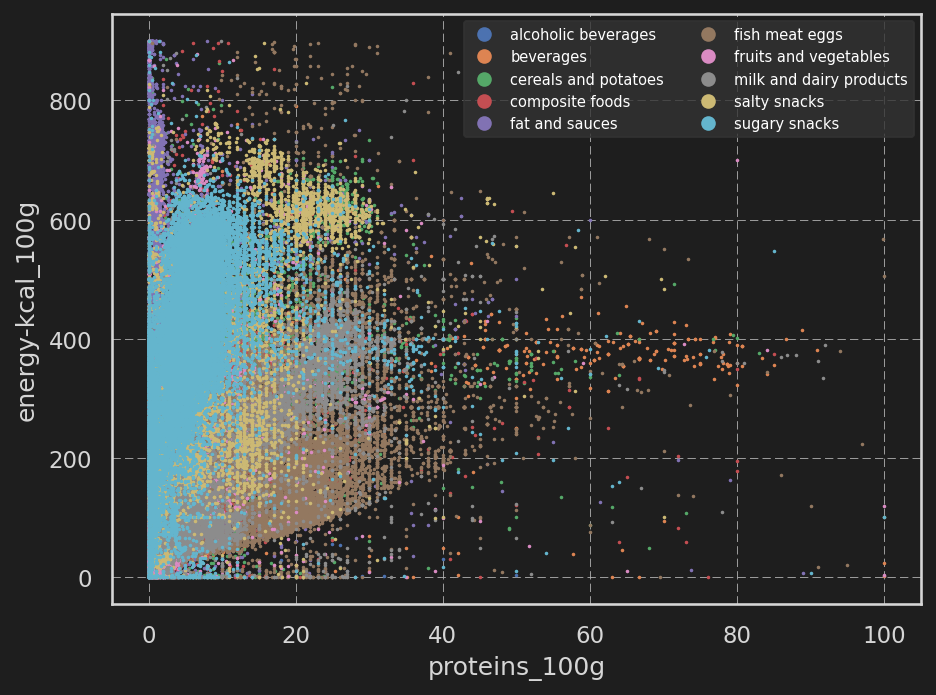

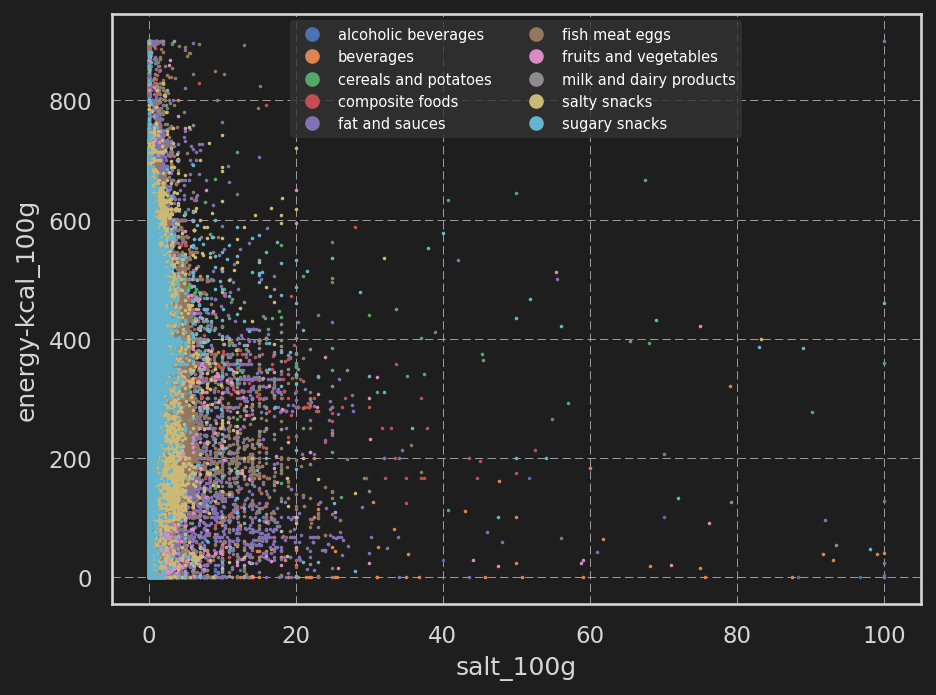

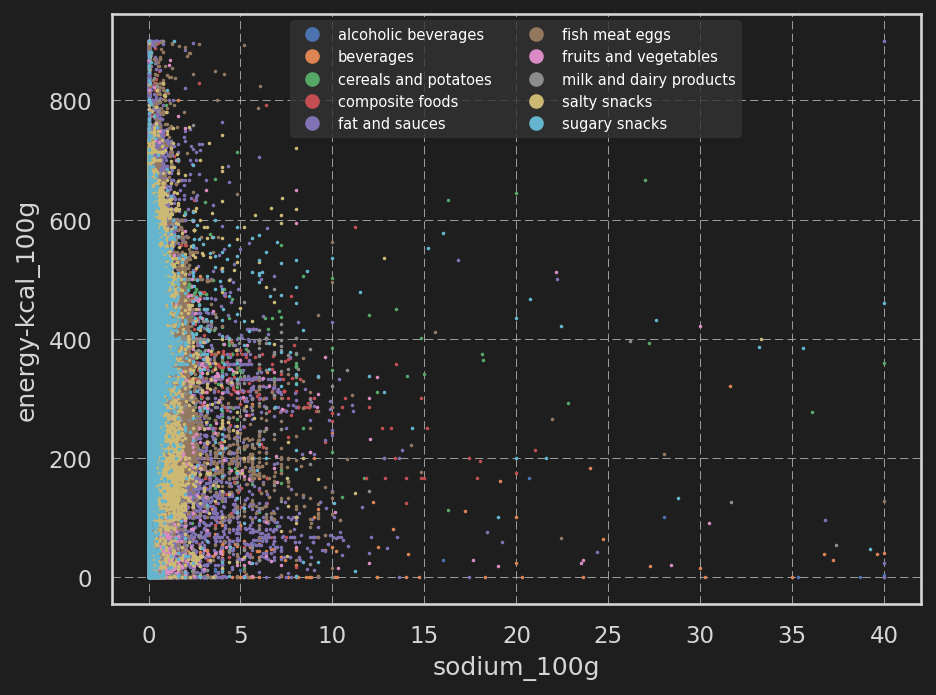

In [109]:
groups = data_stats.groupby( key_categ )

for key in keys_input:
    fig, ax = plt.subplots()
    ax.set_xlabel( key )
    ax.set_ylabel( key_output )
    for name, group in groups:
        ax.plot( group[key], group[key_output], 'o', markersize=0.7, label=name )
    lgnd = ax.legend( ncol=2, fontsize=7 )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend
    fig.tight_layout( )
    plt.show()

# Modelisation
Les entrées <span style="color:orange"> "salt" </span> et <span style="color:orange"> "sodium" </span> sont <span style="color:orange"> retirées </span>, car il n'y a <span style="color:orange"> pas de corrélation visible </span>sur les graphiques

In [126]:
# keys_input_model = keys_stats[ ~keys_stats.str.contains('salt|sodium')]
keys_input_model = keys_stats
display( keys_input_model.tolist() )

['energy-kcal_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

# KNN: classification / Regression

In [98]:
keys_stats.tolist()

['energy-kcal_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
34                 445.0     12.00                7.20               75.00   
39                 286.0      0.00                0.00               71.43   
62                 400.0     20.00               10.00               62.00   
69                 460.0     14.00                1.00               72.00   
76                 535.0     29.50               18.00               60.50   
...                  ...       ...                 ...                 ...   
799872             212.0      0.00                0.00               52.00   
799921             595.0     46.80               26.50               39.90   
799933             440.0     12.00                2.00               44.00   
799982             375.0     17.86               14.29               55.36   
799984             464.0     28.70               16.00               44.40   

        sugars_100g  proteins_100g  salt_100g  sodium_100g  
34            23.00           7.90     1.1000       0.4400  
39            54.29           2.86     0.3575       0.1430  
62            38.00           6.00     0.8250       0.3300  
69            20.00           8.00     1.2000       0.4800  
76            59.50           5.60     0.1500       0.0600  
...             ...            ...        ...          ...  
799872        52.00           1.00     0.0000       0.0000  
799921        34.80          10.80     0.1650       0.0660  
799933        24.00          29.00     0.0120       0.0048  
799982        14.29           3.57     0.9375       0.3750  
799984        13.70           6.30     0.9500       0.3800  

[47321 rows x 8 columns]

xtrain (111808, 8) ytrain (111808,)
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10


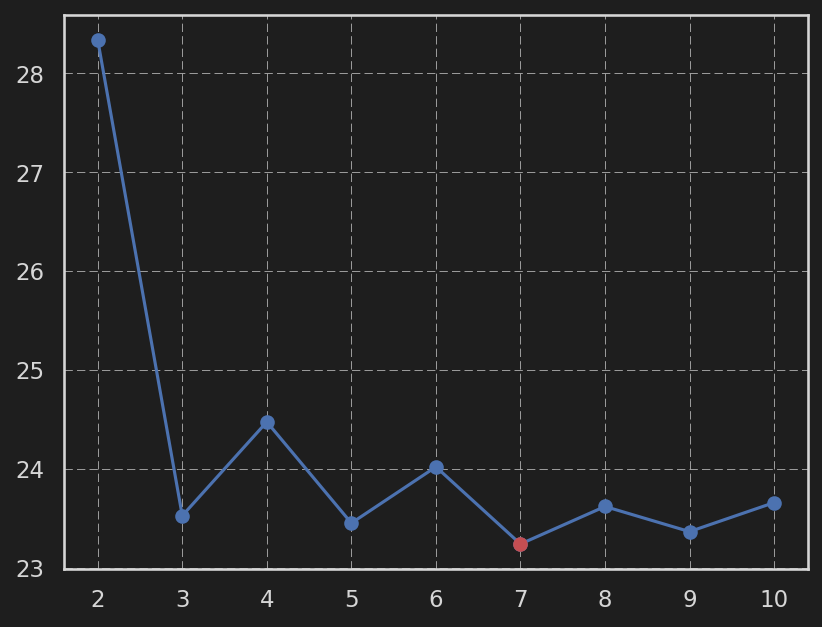

In [133]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors



display( group[keys_stats] )

xtrain, xtest, ytrain, ytest = train_test_split( data_stats[keys_input_model].values , data_stats[key_classification].values, train_size=0.8)
print('xtrain', xtrain.shape, 'ytrain', ytrain.shape )


kmin, kmax = 2, 10
fig, ax = plt.subplots()
errors, dico_knn = [], {}
for k in range(kmin, kmax+1):
    print('k:', k)
    if ytrain.dtype in ['object', 'category']:
        knn = neighbors.KNeighborsClassifier(k)
    else:
        knn = neighbors.KNeighborsRegressor(k)
    dico_knn[k] = knn
    knn.fit(xtrain, ytrain)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
imin = np.argmin(errors)
ax.plot( range(kmin, kmax+1), errors, 'o-b')
ax.plot( [kmin+imin], [errors[imin]], 'or' )
plt.show()


In [137]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

X_fit = [[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]]
print('X_fit:\n', X_fit)
imp.fit( X_fit )
IterativeImputer(random_state=0)
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print('completed X_test:\n', np.round(imp.transform(X_test)))

X_fit:
 [[1, 2], [3, 6], [4, 8], [nan, 3], [7, nan]]
completed X_test:
 [[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


# <span style="color:orange"> FIN PARTIE UTILE </span>

# Labels
Several labels per product

In [ ]:
key = 'labels_en'

print('Example of labels:\n')
i = 0
for value in data[key]:
        if value is np.nan : continue
        print(value)
        i += 1
        if i == 10: break
dico_value_labels = tools.value_count_labels_in_string_series( data.loc[~data[key].isnull(),key] , ',' )
print(dico_value_labels)

# Visiualisation of NaN with missingno
as barplot 

In [ ]:
msno.bar( data )

# Heatmap without fully filled categories

In [ ]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

# Heatmap without fully filled categories (qualitatives + nutriscore)

In [ ]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

# A REGARDER

df = pd.DataFrame({"value": np.random.randint(0, 100, 20)})

labels = ["{0} - {1}".format(i, i + 9) for i in range(0, 100, 10)]

df["group"] = pd.cut(df.value, range(0, 105, 10), right=False, labels=labels)

df.head(10)
Out[9]: 
   value    group
0     65  60 - 69
1     49  40 - 49
2     56  50 - 59
3     43  40 - 49
4     43  40 - 49
5     91  90 - 99
6     32  30 - 39
7     87  80 - 89
8     36  30 - 39
9      8    0 - 9



s.str.contains('foo|bar', na=False, regex=False)
# na to manage nan (to False)
# regex=False to speed up, when regex-based search is not needed

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

How do I select by partial string from a pandas DataFrame?
This post is meant for readers who want to

search for a substring in a string column (the simplest case) as in df1[df1['col'].str.contains(r'foo(?!$)')]
search for multiple substrings (similar to isin), e.g., with df4[df4['col'].str.contains(r'foo|baz')]
match a whole word from text (e.g., "blue" should match "the sky is blue" but not "bluejay"), e.g., with df3[df3['col'].str.contains(r'\bblue\b')]
match multiple whole words
Understand the reason behind "ValueError: cannot index with vector containing NA / NaN values" and correct it with str.contains('pattern',na=False)
...and would like to know more about what methods should be preferred over others.

(P.S.: I've seen a lot of questions on similar topics, I thought it would be good to leave this here.)

Friendly disclaimer, this is post is long.

Basic Substring Search
# setup
df1 = pd.DataFrame({'col': ['foo', 'foobar', 'bar', 'baz']})
df1

      col
0     foo
1  foobar
2     bar
3     baz
str.contains can be used to perform either substring searches or regex based search. The search defaults to regex-based unless you explicitly disable it.

Here is an example of regex-based search,

# find rows in `df1` which contain "foo" followed by something
df1[df1['col'].str.contains(r'foo(?!$)')]

      col
1  foobar
Sometimes regex search is not required, so specify regex=False to disable it.

#select all rows containing "foo"
df1[df1['col'].str.contains('foo', regex=False)]
# same as df1[df1['col'].str.contains('foo')] but faster.
   
      col
0     foo
1  foobar
Performance wise, regex search is slower than substring search:

df2 = pd.concat([df1] * 1000, ignore_index=True)

%timeit df2[df2['col'].str.contains('foo')]
%timeit df2[df2['col'].str.contains('foo', regex=False)]

6.31 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.8 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Avoid using regex-based search if you don't need it.

Addressing ValueErrors
Sometimes, performing a substring search and filtering on the result will result in

ValueError: cannot index with vector containing NA / NaN values
This is usually because of mixed data or NaNs in your object column,

s = pd.Series(['foo', 'foobar', np.nan, 'bar', 'baz', 123])
s.str.contains('foo|bar')

0     True
1     True
2      NaN
3     True
4    False
5      NaN
dtype: object


s[s.str.contains('foo|bar')]
# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
Anything that is not a string cannot have string methods applied on it, so the result is NaN (naturally). In this case, specify na=False to ignore non-string data,

s.str.contains('foo|bar', na=False)

0     True
1     True
2    False
3     True
4    False
5    False
dtype: bool
How do I apply this to multiple columns at once?
The answer is in the question. Use DataFrame.apply:

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

       A      B
0   True   True
1   True  False
2  False   True
3   True  False
4  False  False
5  False  False
All of the solutions below can be "applied" to multiple columns using the column-wise apply method (which is OK in my book, as long as you don't have too many columns).

If you have a DataFrame with mixed columns and want to select only the object/string columns, take a look at select_dtypes.

Multiple Substring Search
This is most easily achieved through a regex search using the regex OR pipe.

# Slightly modified example.
df4 = pd.DataFrame({'col': ['foo abc', 'foobar xyz', 'bar32', 'baz 45']})
df4

          col
0     foo abc
1  foobar xyz
2       bar32
3      baz 45

df4[df4['col'].str.contains(r'foo|baz')]

          col
0     foo abc
1  foobar xyz
3      baz 45
You can also create a list of terms, then join them:

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

          col
0     foo abc
1  foobar xyz
3      baz 45
Sometimes, it is wise to escape your terms in case they have characters that can be interpreted as regex metacharacters. If your terms contain any of the following characters...

. ^ $ * + ? { } [ ] \ | ( )
Then, you'll need to use re.escape to escape them:

import re
df4[df4['col'].str.contains('|'.join(map(re.escape, terms)))]

          col
0     foo abc
1  foobar xyz
3      baz 45
re.escape has the effect of escaping the special characters so they're treated literally.

re.escape(r'.foo^')
# '\\.foo\\^'


# END OF NOTEBOOK

In [ ]:
fig = ax.get_figure()
fig.tight_layout()
tools.savefig( fig, 'Figures/test' )